Contributions of this notebook:
1. Create `demo_data.csv`, a summary of demographic features (race and gender) in the eICU dataset 
2. Get high-level idea of how data addition affects subgroup accuracy (heatmaps)
3. Analyze impacts of data balancing (subgroup rate and subgroup sample count) on accuracy

In [1]:
import os, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pathlib import Path
from scipy.stats import pearsonr

n = 1000
model = "LogisticRegression"
metric = "ACC_TEST"
base_log_dir = Path(f"../../yaib_logs/eicu/Mortality24/{model}/")

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    

map_race = {0: 'asian', 
            1: 'black',
            2: 'other',
            3: 'white'}

map_gender = {0: 'Female', 1: 'Male'}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

reverse_map_attribute = {'asian': 'race0',
                         'black': 'race1',
                         'other': 'race2',
                         'white': 'race3',
                         'Female': 'gender0',
                         'Male': 'gender1'}

format_metric = {'ACC': 'Test Accuracy',
                 'ACC_TEST': 'Test Accuracy',
                 'AUC_TEST': 'Test AUC',
                 'AUC': 'Test AUC'}

In [2]:
# get base AUC and ACC test performance
hospital_data = {}
for i in range(len(hospital_ids)):
    hospital_data[hospital_ids[i]] = {}

base_avg = np.load(f"../results/base/{model}-n{n}-avg.npz", allow_pickle=True)
metrics = list(base_avg.files)

for i, hos in enumerate(hospital_ids):
    hospital_data[hos]["AUC_TEST"] = base_avg["AUC_TEST"].item()[hos]
    hospital_data[hos]["ACC_TEST"] = base_avg["ACC_TEST"].item()[hos]
    
    for met in ["ACC_TEST", "AUC_TEST"]:
        min_auc = float('inf')
        min_metric = None
        
        for eth in range(1,4):
            auc_value = base_avg[f'race{eth}_{met}'].item()[hos]
            if auc_value < min_auc:
                min_auc = auc_value
                min_metric = map_race[eth]
            hospital_data[hospital_ids[i]][f'{map_attribute[f"race{eth}"]}_{met}'] = auc_value
        
        hospital_data[hospital_ids[i]][f"worst_{met}_subgroup"] = min_metric.split("_")[0]

#### Get Race and Gender Data

In [3]:
df = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df = df.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df = df.rename(columns={'hospitalid': 'hosp_id'})

# add outcome data
df_outc = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/outc.parquet', engine='pyarrow')

df = df.merge(df_outc, on='stay_id')

# Create a new dataframe df1 grouped by hosp_id
df1 = df.groupby('hosp_id').agg(
    count=('stay_id', 'count'),
    white_count=('ethnic', lambda x: (x == 'white').sum()),
    black_count=('ethnic', lambda x: (x == 'black').sum()),
    other_count=('ethnic', lambda x: (x == 'other').sum()),
    asian_count=('ethnic', lambda x: (x == 'asian').sum()),
    mort_rate=('label', 'mean')
)

# get subgroup level mort rates
df2 = (
    df.groupby('hosp_id')
    .apply(
        lambda g: pd.Series({
            'white_mort_rate': g.loc[g['ethnic'] == 'white', 'label'].mean(),
            'black_mort_rate': g.loc[g['ethnic'] == 'black', 'label'].mean(),
            'other_mort_rate': g.loc[g['ethnic'] == 'other', 'label'].mean(),
            'asian_mort_rate': g.loc[g['ethnic'] == 'asian', 'label'].mean(),
        })
    )
)
df1 = df1.merge(df2, on='hosp_id', how='left')

# Calculate base rates for each ethnic group
total_counts = df1['white_count'] + df1['black_count'] + df1['other_count'] + df1['asian_count']
df1['white_rate'] = df1['white_count'] / total_counts
df1['black_rate'] = df1['black_count'] / total_counts
df1['other_rate'] = df1['other_count'] / total_counts
df1['asian_rate'] = df1['asian_count'] / total_counts

# Calculate counts for each gender
df1['male_count'] = df.groupby('hosp_id')['sex'].apply(lambda x: (x == 'Male').sum())
df1['female_count'] = df.groupby('hosp_id')['sex'].apply(lambda x: (x == 'Female').sum())

# Calculate rates for each gender
df1['male_rate'] = df1['male_count'] / df1['count']
df1['female_rate'] = df1['female_count'] / df1['count']

# Filter df1 to keep only hosp_ids in hospital_ids
df1 = df1[df1.index.isin(hospital_ids)]
df1 = df1.reset_index()
df1['hosp_id'] = df1['hosp_id'].astype(int)

# Sort the dataframe based on the order in hospital_ids
df1 = df1.set_index('hosp_id').loc[hospital_ids].reset_index()

# Add data from hospital_data to df1
for hosp_id, data in hospital_data.items():
    for key, value in data.items():
        df1.loc[df1['hosp_id'] == hosp_id, key] = value
        
df1 = df1.round(4)  # Round to 4 decimal places for readability

# Define general columns
general_columns = ['hosp_id', 'count', 'AUC_TEST', 'ACC_TEST', 'mort_rate']

# Define race-specific columns
race_columns = ['white_count', 'black_count', 'other_count', 'asian_count',
                'white_rate', 'black_rate', 'other_rate', 'asian_rate',
                'white_mort_rate', 'black_mort_rate', 'other_mort_rate', 'asian_mort_rate',
                'white_AUC_TEST', 'black_AUC_TEST', 'other_AUC_TEST',# 'asian_AUC_TEST', 
                'white_ACC_TEST', 'black_ACC_TEST', 'other_ACC_TEST', #'asian_ACC_TEST', 
                'worst_ACC_TEST_subgroup']

# Define gender-specific columns
gender_columns = ['male_count', 'female_count', 'male_rate', 'female_rate', 'Male_auc', 'Female_auc', 'Male_acc', 'Female_acc', 'worst_gender_subgroup']

# Create df_race
df_race = df1[general_columns + race_columns].copy()

# Create df_gender
# df_gender = df1[general_columns + gender_columns].copy()

# Sort df_race and df_gender by hospital_id
df_race = df_race.sort_values('hosp_id')
# df_gender = df_gender.sort_values('hosp_id')

df_race_acc = df_race[["hosp_id", "count", "white_ACC_TEST", "black_ACC_TEST", "other_ACC_TEST"]]
df_race_acc["min_ACC_TEST_subgroup"] = df_race_acc[["black_ACC_TEST", "other_ACC_TEST", "white_ACC_TEST"]].idxmin(axis=1)
df_race_acc["min_ACC_TEST_subgroup"] = df_race_acc["min_ACC_TEST_subgroup"].str.replace("_ACC_TEST", "")

if not os.path.exists('demo_data.csv'):
    df_race.to_csv('demo_data.csv', index=False) 

/tmp/ipykernel_381835/4165631145.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_race_acc["min_ACC_TEST_subgroup"] = df_race_acc[["black_ACC_TEST", "other_ACC_TEST", "white_ACC_TEST"]].idxmin(axis=1)
/tmp/ipykernel_381835/4165631145.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_race_acc["min_ACC_TEST_subgroup"] = df_race_acc["min_ACC_TEST_subgroup"].str.replace("_ACC_TEST", "")


### Data Addition Results

Whole hospital data addition results

In [4]:
add_data_avg = np.load(f"../results/add_data/{model}-n{n}-avg.npz", allow_pickle=True)
add_data_std = np.load(f"../results/add_data/{model}-n{n}-std.npz", allow_pickle=True)
add_data_ci = np.load(f"../results/add_data/{model}-n{n}-ci.npz", allow_pickle=True)

auc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*AUC.*').match(metric)]
bacc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*BACC.*').match(metric)]
acc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*ACC.*').match(metric)]

acc_metrics = list(set(acc_metrics) - set(bacc_metrics))

base_columns = ['hosp_id', 'count', 'AUC', 'ACC']

In [5]:
addition_data = {} # {metric: results_arr}

# overall metric
addition_data[metric] = add_data_avg[metric]
addition_data[f"{metric}_diff"] = add_data_avg[metric] - [hospital_data[hos][metric] for hos in hospital_ids]

# subgroup metrics
for i, subgroup in map_race.items():
    if i == 0:
        continue # skip asian
    
    add_data = add_data_avg[f"race{i}_{metric}"] # 12 x 12 arr
    base_data = [hospital_data[hos][f"{subgroup}_{metric}"] for hos in hospital_ids] # 12 x 1 arr
    
    addition_data[f"race{i}_{metric}"] = add_data
    addition_data[f"race{i}_{metric}_diff"] = add_data - base_data  

In [6]:
datapoints = {subgroup: [] for subgroup in ['black', 'other', 'white']}


for j, test_hos in enumerate(hospital_ids):
    for k, train_hos in enumerate(hospital_ids):
        if j != k:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
            exp_dir = os.path.join(base_log_dir, dir_str)
            files = os.listdir(exp_dir)
            files.sort()
            datetime = files[-1]
            
            patient_results = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))
            
            train_ids = patient_results['train_ids']
            train_races = patient_results['train_races']

            train_hosps = pd.DataFrame({'stay_id': train_ids}).merge(df, on='stay_id')['hosp_id'].values
            
            samples_added = np.sum(train_hosps == train_hos)
            for i, subgroup in enumerate(['black', 'other', 'white'], start=1):
                rate_new = (np.sum(train_races==i) / len(train_races)) 
                rate_base = (np.sum((train_races==i) & (train_hosps==test_hos)) / np.sum(train_hosps==test_hos))
                rate_change = rate_new - rate_base
                
                metric_change = addition_data[f"race{i}_{metric}_diff"][k, j]
                if not np.isnan(metric_change):
                    datapoints[subgroup].append((rate_change, metric_change))
                            

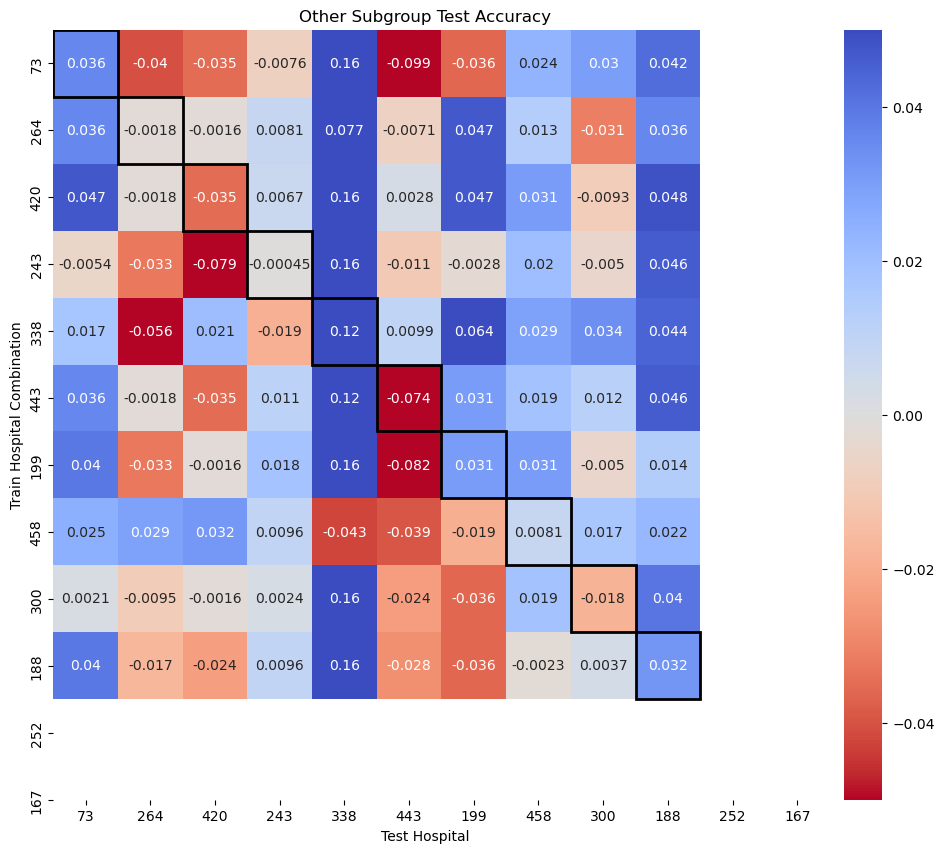

In [9]:
col = 'race1_ACC_TEST'  # or 'ACC_TEST'

# Get base values and reshape to match the matrix dimensions
base_values = np.array([base_avg[col].item()[hos] for hos in base_avg[col].item().keys()]).reshape(1, -1)

# Calculate the difference between avg_dict and base values
plot_data = add_data_avg[col] - base_values
plot_data = plot_data[:10, :10]

plt.figure(figsize=(12, 10))

# Create diverging colormap centered at 0
cmap = sns.diverging_palette(240, 15, s=95, l=40, as_cmap=True)
min_val = np.nanmin(plot_data)
max_val = np.nanmax(plot_data)
limit = max(abs(min_val), abs(max_val))
limit = 0.05

# Create heatmap
ax = sns.heatmap(plot_data, annot=True, cmap='coolwarm_r', 
            xticklabels=hospital_ids, yticklabels=hospital_ids, 
            vmin=-limit, vmax=limit, center=0)

# Outline the diagonal cells
num_rows, num_cols = plot_data.shape
for i in range(min(num_rows, num_cols)):
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2)
    ax.add_patch(rect)

plt.title(f"Other Subgroup {format_metric[metric]}")
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital Combination")
plt.show()

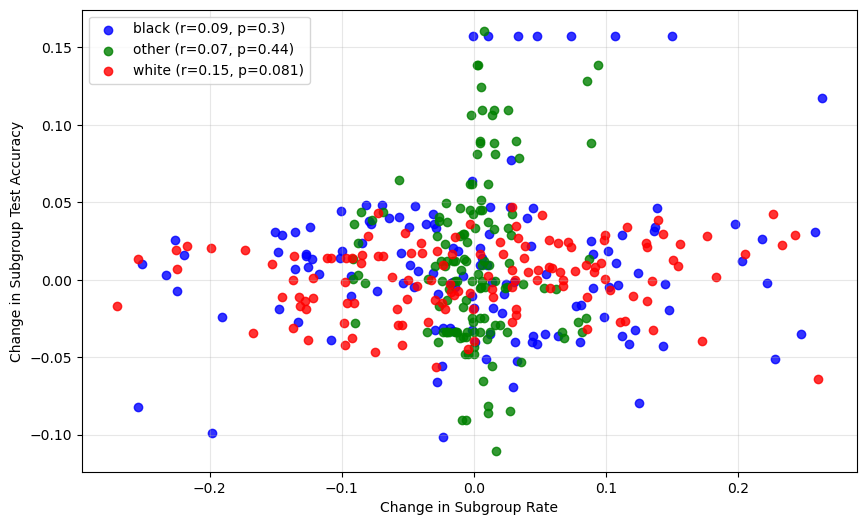

In [8]:
# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}
for subgroup, data in datapoints.items():
    # if len(data) > 0:  # Only plot if we have data for this subgroup
    x_group = [point[0] for point in data]
    y_group = [point[1] for point in data]
    
    # Compute correlation coefficient and p-value for this subgroup
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the subgroup
    plt.scatter(x_group, y_group, 
                label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})", 
                color=colors[subgroup], 
                alpha=0.8)

plt.xlabel('Change in Subgroup Rate')
plt.ylabel('Change in Subgroup Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

### Subgroup Data Addition Results

In [14]:
add_subg_avg = np.load(f"../results/add_subgroup/{model}-n{n}-avg.npz", allow_pickle=True)
add_subg_std = np.load(f"../results/add_subgroup/{model}-n{n}-std.npz", allow_pickle=True)
add_subg_ci = np.load(f"../results/add_subgroup/{model}-n{n}-ci.npz", allow_pickle=True)

auc_metrics = [metric for metric in add_subg_avg.files if re.compile(r'.*AUC.*').match(metric)]
bacc_metrics = [metric for metric in add_subg_avg.files if re.compile(r'.*BACC.*').match(metric)]
acc_metrics = [metric for metric in add_subg_avg.files if re.compile(r'.*ACC.*').match(metric)]

acc_metrics = list(set(acc_metrics) - set(bacc_metrics))

base_columns = ['hosp_id', 'count', 'AUC_TEST', 'ACC_TEST']

In [15]:
subg_addition_data = {subgroup: {} for subgroup in map_race.values()} # {added_subgroup: {metric: results_arr}}

for j, added_subgroup in map_race.items():
    if j != 0:
        # overall metric
        subg_addition_data[added_subgroup][metric] = add_subg_avg[added_subgroup].item()[metric]
        subg_addition_data[added_subgroup][f"{metric}_diff"] = add_subg_avg[added_subgroup].item()[metric] - [hospital_data[hos][metric] for hos in hospital_ids]

        # subgroup metrics
        for i, target_subgroup in map_race.items():
            if i == 0:
                continue # skip asian
            
            add_data = add_subg_avg[added_subgroup].item()[f"race{i}_{metric}"] # 12 x 12 arr
            base_data = [hospital_data[hos][f"{target_subgroup}_{metric}"] for hos in hospital_ids] # 12 x 1 arr
            
            subg_addition_data[added_subgroup][f"race{i}_{metric}"] = add_data
            subg_addition_data[added_subgroup][f"race{i}_{metric}_diff"] = add_data - base_data  

**Figure**: count of subgroup samples added vs. change in performance

In [40]:
# datapoints = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
datapoints = {subgroup: {hos: [] for hos in hospital_ids} for subgroup in map_race.values() if subgroup != 'asian'}


for i, subgroup in map_race.items():
    if i != 0:
        for j, test_hos in enumerate(hospital_ids):
            for k, train_hos in enumerate(hospital_ids):
                if j != k:
                    dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-{subgroup}-n{n}"
                    exp_dir = os.path.join(base_log_dir, dir_str)
                    files = os.listdir(exp_dir)
                    files.sort()
                    datetime = files[-1]
                    
                    patient_results = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))
                    
                    train_ids = patient_results['patient_ids']
                    train_races = patient_results['patient_races']

                    # train_hosps = pd.DataFrame({'stay_id': train_ids}).merge(df, on='stay_id')['hosp_id'].values
                    # samples_added = np.sum(train_hosps == train_hos)
                    #assert np.all(train_races[(train_hosps == train_hos)] == i), f"Not all samples from hospital {train_hos} have race {i}"
                    
                    samples_added = df_race.loc[df_race.hosp_id == train_hos][f"{subgroup}_count"].item()

                    rate_new = (np.sum(train_races==i) / len(train_races)) 
                    rate_base = (np.sum((train_races==i) & (train_hosps==test_hos)) / np.sum(train_hosps==test_hos))
                    rate_change = rate_new - rate_base
                    
                    metric_change = subg_addition_data[subgroup][f"race{i}_{metric}_diff"][k, j]
                    datapoints[subgroup][test_hos].append((samples_added, metric_change))
                        

/tmp/ipykernel_229732/347881535.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  rate_new = (np.sum(train_races==i) / len(train_races))
/tmp/ipykernel_229732/347881535.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  rate_base = (np.sum((train_races==i) & (train_hosps==test_hos)) / np.sum(train_hosps==test_hos))
/tmp/ipykernel_229732/347881535.py:28: RuntimeWarning: invalid value encountered in scalar divide
  rate_base = (np.sum((train_races==i) & (train_hosps==test_hos)) / np.sum(train_hosps==test_hos))


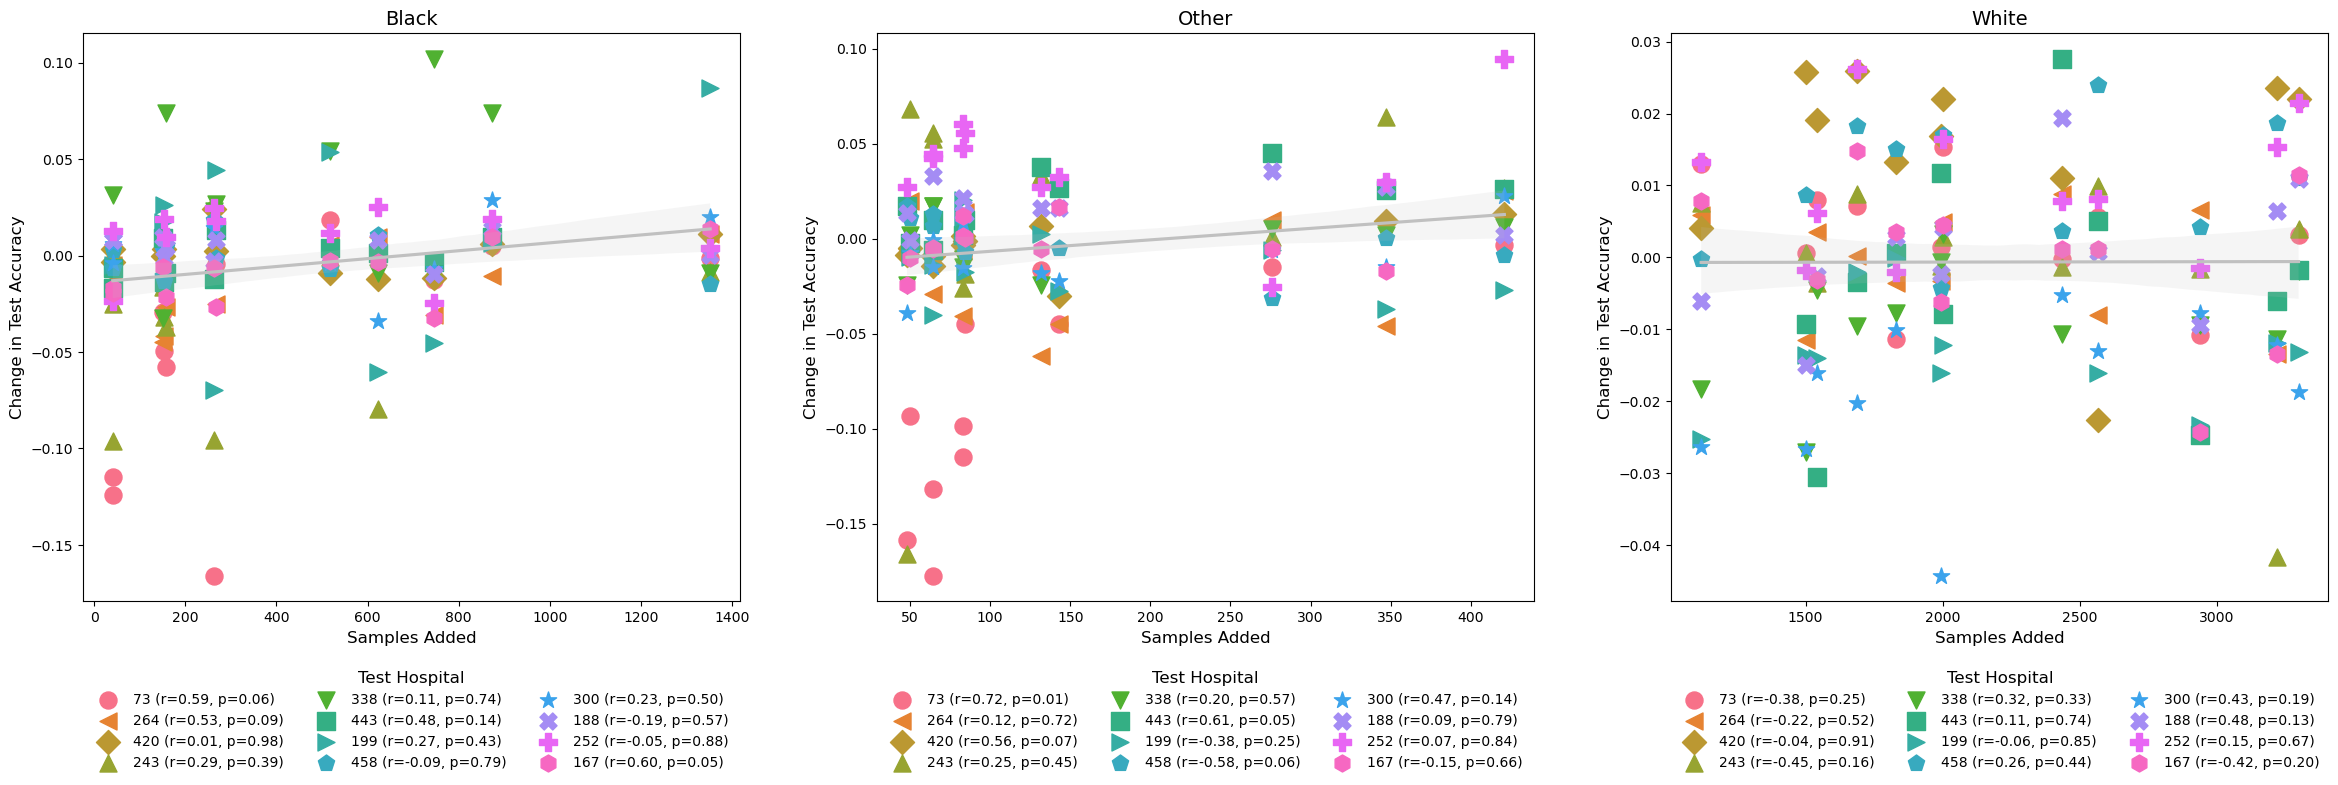

In [41]:
# Create figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Increased height to accommodate legends

# Define 12 unique colors and markers
palette = sns.color_palette("husl", len(hospital_ids))
markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']

# Plot for each subgroup
for idx, (subgroup, ax) in enumerate(zip(datapoints.keys(), axes)):
    correlation_dict = {}
    all_x = []
    all_y = []

    # Plot points for each hospital
    for i, test_hospital in enumerate(hospital_ids):
        x = np.array([pt[0] for pt in datapoints[subgroup][test_hospital]], dtype=float)
        y = np.array([pt[1] for pt in datapoints[subgroup][test_hospital]], dtype=float)

        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]
        
        # Store all points for overall correlation
        all_x.extend(x)
        all_y.extend(y)
        
        
        # Calculate correlation for this hospital
        corr_coef, p_value = pearsonr(x, y)
        correlation_dict[test_hospital] = (corr_coef, p_value)
        
        # Plot points for this hospital
        ax.scatter(x, y, 
                  label=f'{test_hospital} (r={corr_coef:.2f}, p={p_value:.2f})',
                  color=palette[i],
                  marker=markers[i],
                  s=150)

    # Add regression line for all points
    sns.regplot(x=all_x, y=all_y, 
                scatter=False, color='silver', ax=ax)

    # Compute overall correlation
    overall_corr, overall_p = pearsonr(all_x, all_y)

    # Customize legend position and title
    ax.legend(loc='upper center', 
              bbox_to_anchor=(0.5, -0.1),  # Position below the plot
              frameon=False, 
              fontsize=10,
              ncol=3).set_title('Test Hospital', prop={'size': 12})

    # Set axis labels
    ax.set_xlabel('Samples Added', fontsize=12)
    ax.set_ylabel(f'Change in {format_metric[metric]}', fontsize=12)
    ax.set_title(f'{subgroup.capitalize()}', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()